In [4]:
import os
#for zooming in the plots produced
os.system("pip install mpld3")

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
mpld3.enable_notebook()


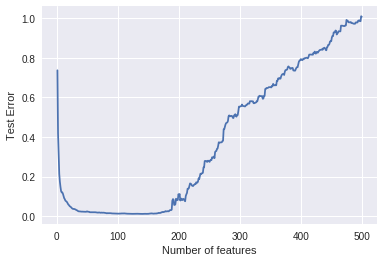

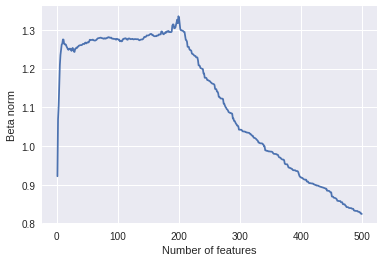

In [5]:
#Reproducing double descent curve obtained in 'Two models of double descent for weak features' for misspecified model under gaussian assumption
np.random.seed(1234)
n_features = 500
n_train_samples = 200
n_test_samples = 200

#Random betas, specify the one that is needed  - 1/t or 1/t^2
# betas = np.random.normal(0, 1, (n_features, 1))
#Prescient feature selection : beta = 1/t
betas = np.zeros((n_features, 1))
for j in range(n_features):
    betas[j, 0] = 1/(j+1)
#Prescient feature selection : beta = 1/(t*t)
# betas = np.zeros((n_features, 1))
# for j in range(n_features):
#     betas[j, 0] = 1/((j+1)*(j+1))



x_train = np.random.normal(0, 1, (n_train_samples, n_features))
x_test = np.random.normal(0, 1, (n_test_samples, n_features))
y_train = np.matmul(x_train, betas)
y_test = np.matmul(x_test, betas)
error = []
beta_norm = []

no_vars = 500

for i in range(1, no_vars):
    A_temp = x_train[:, 0:i]
    beta_hat = np.matmul(np.linalg.pinv(A_temp), y_train)
    beta_norm.append(np.linalg.norm(beta_hat))
    y_pred = np.matmul(x_test[:, 0:i], beta_hat)
    error.append(np.power(np.linalg.norm(y_pred - y_test), 2)/n_test_samples)

plt.plot(list(range(1, no_vars)), error)
plt.xlabel('Number of features')
plt.ylabel('Test Error')
plt.show()
plt.plot(list(range(1, no_vars)), beta_norm)
plt.xlabel('Number of features')
plt.ylabel("Beta norm")
plt.show();

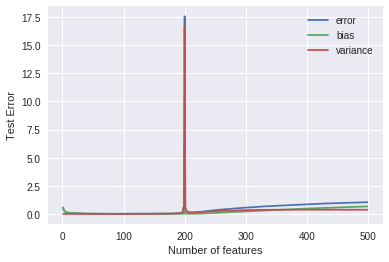

In [6]:
#Bias-Variance analysis of the double descent curve obtained above
#Zoom in the plot to look at it closely

np.random.seed(1234)
n_features = 500
n_train_samples = 200
n_test_samples = 200

#Random betas
# betas = np.random.normal(0, 1, (n_features, 1))
#Prescient selection of features: beta = 1/t
betas = np.zeros((n_features, 1))
for j in range(n_features):
  betas[j, 0] = 1/(j+1)
#Prescient selection of features: beta = 1/(t*t)
# betas = np.zeros((n_features, 1))
# for j in range(n_features):
#   betas[j, 0] = 1/((j+1)*(j+1))

no_train_sets = 20

x_train = np.random.normal(0, 1, (no_train_sets, n_train_samples, n_features))
x_test = np.random.normal(0, 1, (n_test_samples, n_features))
y_test = np.matmul(x_test, betas)
bias = []
variance = []
error = []
beta_norm = []

no_vars = 500

for i in range(1, no_vars):
    beta_hats = np.zeros((i, no_train_sets))
    for j in range(no_train_sets):
        x_train_temp = x_train[j]
        A_temp = x_train_temp[:, 0:i]
        y_train = np.matmul(x_train_temp, betas)
        beta_hat = np.matmul(np.linalg.pinv(A_temp), y_train)
        beta_hats[:, j] = np.ravel(beta_hat)

    E_beta_hat = np.sum(beta_hats, 1, keepdims=True)/no_train_sets
    y_pred = np.matmul(x_test[:, 0:i], E_beta_hat)
    bias_i = np.power(np.linalg.norm(y_pred - y_test), 2)/n_test_samples
    bias.append(bias_i)
    
    var = 0
    for ind in range(no_train_sets):
        beta = np.reshape(beta_hats[:, ind], (i, 1))
        y_pred_temp = np.matmul(x_test[:, 0:i], beta)
        var = var + (np.power(np.linalg.norm(y_pred_temp - y_pred), 2)/(n_test_samples*no_train_sets))
    variance.append(var)

    err = 0
    for ind in range(no_train_sets):
        beta_temp = np.reshape(beta_hats[:, ind], (i, 1))
        y_pred_temp = np.matmul(x_test[:, 0:i], beta_temp)
        err = err + (np.power(np.linalg.norm(y_pred_temp - y_test), 2))/(n_test_samples*no_train_sets)
    error.append(err)

plt.plot(list(range(1, no_vars)), error)
plt.plot(list(range(1, no_vars)), bias)
plt.plot(list(range(1, no_vars)), variance)
plt.legend(['error', 'bias', 'variance'])
plt.xlabel('Number of features')
plt.ylabel('Test Error')
plt.show()

In [7]:
def random_covar(n):
    diag = np.diag(np.linspace(1, 100, n))
    u = np.random.normal(0, 1, (n, 1))
    t = 2/np.matmul(u.T, u)
    mat = np.eye(n) - t*np.matmul(u, u.T)
    return np.matmul(mat, np.matmul(diag, mat)), mat

17.894138123086293
84.51290889255986
107.7180539318287
139.52059672294962
164.38720738569512
169.66279655123293


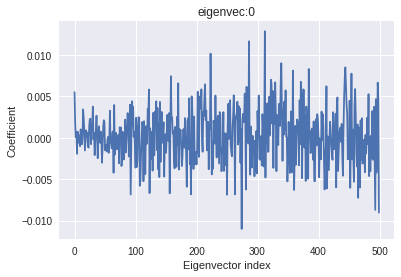

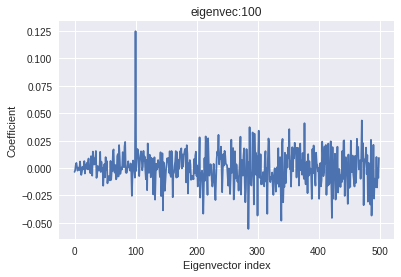

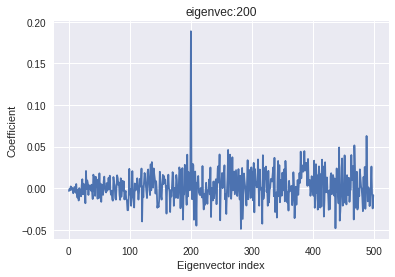

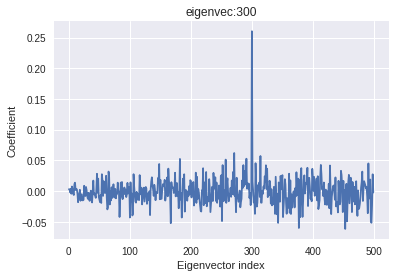

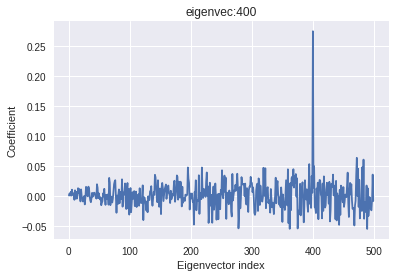

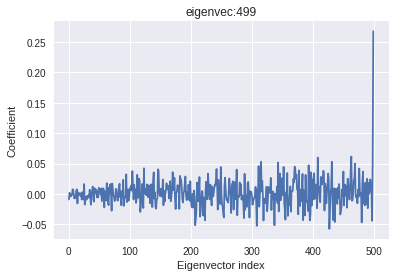

In [8]:
# Observing that signal bleed decreases as Y is explained using the top eigenvectors of the covariance matrix of X
np.random.seed(2167)
n_features = 500
n_train_samples = 300
n_test_samples = 2000
covar, mat = random_covar(n_features)
x_train = np.random.multivariate_normal(np.zeros((n_features)), covar, (n_train_samples))
x_test = np.random.multivariate_normal(np.zeros((n_features)), covar, (n_test_samples))


train_points = [100]#[25, 50, 100, 150, 200, 250, 300]

eigs = [0, 100, 200, 300, 400, 499]
final_beta = []
final_error = np.zeros((len(eigs), len(train_points)))

for index, j in enumerate(eigs):
    y_train = np.matmul(x_train, mat[:, j]) + np.random.normal(0, 0.1, n_train_samples)
    print(np.linalg.norm(y_train))
    y_test = np.matmul(x_test, mat[:, j]) + np.random.normal(0, 0.1, n_test_samples)
    for index2, i in enumerate(train_points):
        A_temp = x_train[0:i, :]
        beta_hat = np.matmul(np.linalg.pinv(A_temp), y_train[0:i])
        final_beta.append(np.matmul(mat, beta_hat))
        y_pred = np.matmul(x_test, beta_hat)
        final_error[index, index2] = np.power(np.linalg.norm(y_pred - y_test), 2)/n_test_samples

for i in range(len(final_beta)):
    plt.plot(list(range(n_features)), final_beta[i])
    plt.xlabel('Eigenvector index')
    plt.ylabel('Coefficient')
    plt.title('eigenvec:' + str(eigs[i]))
    plt.show()

17.99932320704006
18.505804733891477
17.059850634800764
17.885144198924632
18.31040694509872
16.879256846613565


/home/depen/.local/lib/python3.6/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/home/depen/.local/lib/python3.6/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/home/depen/.local/lib/python3.6/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/home/depen/.local/lib/python3.6/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/home/depen/.local/lib/python3.6/site-packages/mpld3/_display.py:138: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  return numpy.asscalar(obj)
/home/depen/.local/lib/python3.6/site-packages/mpld3/_displa

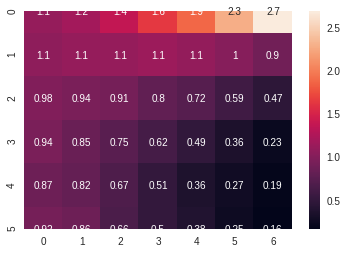

In [9]:
#Observing that test error decreases as Y is explained using top eigenvectors of covariance matrix
#matplotlib 3.1.1 is not compatible with seaborn heatmap, thats why the error comes up, other versions work fine
train_points = [25, 50, 100, 150, 200, 250, 300]

eigs = [0, 100, 200, 300, 400, 499]
final_beta = []
final_error = np.zeros((len(eigs), len(train_points)))

for index, j in enumerate(eigs):
    #sqrt(5/(j+1)) is a scaling factor to ensure that ||Y|| remains same in expectation for all of them
    #Explanation provided in the pdf
    y_train = np.matmul(x_train, mat[:, j]*np.sqrt(5/(j+5))) + np.random.normal(0, 0.1, n_train_samples)
    print(np.linalg.norm(y_train))
    y_test = np.matmul(x_test, mat[:, j]*np.sqrt(5/(j+5))) + np.random.normal(0, 0.1, n_test_samples)
    for index2, i in enumerate(train_points):
        A_temp = x_train[0:i, :]
        beta_hat = np.matmul(np.linalg.pinv(A_temp), y_train[0:i])
        y_pred = np.matmul(x_test, beta_hat)
        final_error[index, index2] = np.power(np.linalg.norm(y_pred - y_test), 2)/n_test_samples

sns.heatmap(final_error, annot = True)